# Exploratory Data Analysis of Traffic Dataset on the I-94 Highway

This project focuses on analyzing the hourly traffic volume data for westbound I-94 in Minneapolis-St. Paul, MN, spanning from 2012 to 2018. This dataset contains not only traffic volume but also includes weather and holiday-related features. 

My primary objective is to identify key indicators of heavy traffic on this stretch of the I-94 Interstate highway. The aim is to uncover patterns that contribute to increased traffic congestion by investigating various factors such as weather conditions, time of day, and day of the week.

## Data Dictionary
* `holiday` Categorical US National holidays plus regional holiday, Minnesota State Fair
* `temp` Numeric Average temp in kelvin
* `rain_1h` Numeric Amount in mm of rain that occurred in the hour
* `snow_1h` Numeric Amount in mm of snow that occurred in the hour
* `clouds_all` Numeric Percentage of cloud cover
* `weather_main` Categorical Short textual description of the current weather
* `weather_description` Categorical Longer textual description of the current weather
* `date_time` DateTime Hour of the data collected in local CST time
* `traffic_volume` Numeric Hourly I-94 ATR 301 reported westbound traffic volume

## Part 1: Data Exploration

In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 1.1: Basic Data Exploration

In [40]:
interstate = pd.read_csv('Metro_Interstate_Traffic_Volume.csv.gz', compression='gzip')

interstate.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
27020,None,287.46,0.0,0.0,0,Clear,Sky is Clear,2016-10-01 11:00:00,4432
21136,None,269.29,0.0,0.0,90,Mist,mist,2016-02-07 19:00:00,1618
1037,None,284.64,0.0,0.0,75,Clouds,broken clouds,2012-11-09 15:00:00,5958
17026,None,300.20,0.0,0.0,1,Clear,sky is clear,2015-08-01 12:00:00,3926
43056,None,270.22,0.0,0.0,90,Mist,mist,2018-04-09 00:00:00,427


In [41]:
interstate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


Observations from the above table:
* This dataset has 9 columns and 48204 rows. There are 5 numerical columns and 4 columns with string objects
* There are no null or missing values. 
* And the date_time column is stored as object (this needs to be converted to datetime)


### 1.2: Exploring Numerical Columns

In [42]:
interstate.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


From the summary statistics table, we can see that there were times when the traffic volume is 0. Since the `traffic_volume` records hourly traffic on the interstate 1-94, hours with no traffic at all are probably very late at night. This is an assumption that will be checked out. 

Let's check if any of the numerical weather indicators are correlated with traffic volume.

In [43]:
interstate[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']].corr()['traffic_volume']

temp              0.130299
rain_1h           0.004714
snow_1h           0.000733
clouds_all        0.067054
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

There isn't any strong correlation between the weather indicator and traffic volume. But, we can still plot them for visualization.

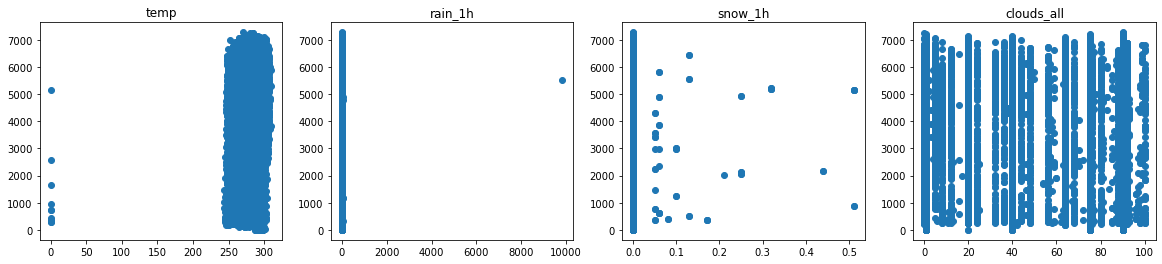

In [44]:
weather_indicators = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']

plt.figure(figsize=(20,4))

for idx, col in enumerate(weather_indicators):
    ax = plt.subplot(1, 4, idx+1)
    plt.scatter(y=interstate['traffic_volume'], x=interstate[col])
    plt.title(col)

It's quite clear that non of these features are good indicators of traffic volume on the I-94

### 1.3: Inspecting the `date_time` column

The `date_time` column contains both date and time of day (hour) of each record. We can use this column to split our dataset into day and night, this will help us to see how traffic volumn differ during various hours of the day and nighttime. 

For the purpose of this analysis, we will make two assumptions:
* Daytime: 7AM to 7PM
* Nighttime: 7PM to 7AM

This will help to keep things simple, plus both daytime and nighttime have 12 hours each. 

In [45]:
# Convert `date_time` column to datetime
interstate['date_time'] = pd.to_datetime(interstate['date_time'])

In [46]:
# Split the data using the date_time column
interstate['is_daytime'] = pd.Series()

interstate.loc[(interstate['date_time'].dt.hour >= 7) & (interstate['date_time'].dt.hour < 19), 'is_daytime'] = 'Yes'

interstate.loc[(interstate['date_time'].dt.hour >= 19) | (interstate['date_time'].dt.hour < 7), 'is_daytime'] = 'No'

interstate['is_daytime'].value_counts(dropna=False)

No     24327
Yes    23877
Name: is_daytime, dtype: int64

In [47]:
interstate[interstate['is_daytime'] == 'Yes']['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [48]:
interstate[interstate['is_daytime'] == 'No']['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

Looking at the 2 tables above, it's very clear that traffic during the day is generally higher than during the night, which is no surpise. 

During the day, there are more than 4252 cars on the road 75% of the time (this is because 25% of the values are less that 4252).

And at night, traffic is generally much lower since traffic volume is below 3000; that is only 530 to 2819 cars are on the road most of the time. 

We can vizualise this distribution with histograms or boxplots.

Text(0.5, 0, 'Traffic Volume')

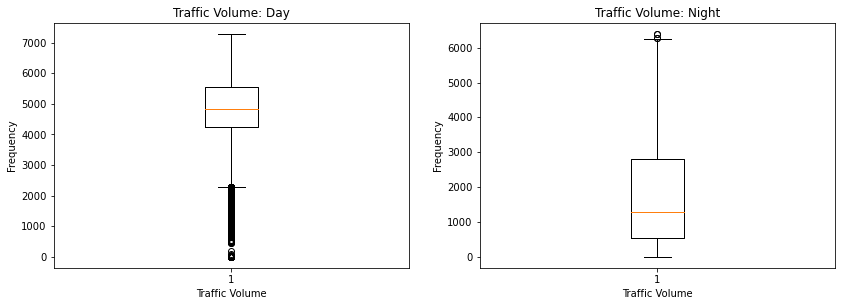

In [49]:
plt.figure(figsize=(14,4.5))

df_day = interstate[interstate['is_daytime'] == 'Yes']
df_night = interstate[interstate['is_daytime'] == 'No']

plt.subplot(1, 2, 1)
plt.boxplot(df_day['traffic_volume'])
plt.title('Traffic Volume: Day')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

plt.subplot(1, 2, 2)
plt.boxplot(df_night['traffic_volume'])
plt.title('Traffic Volume: Night')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

Text(0.5, 0, 'Traffic Volume')

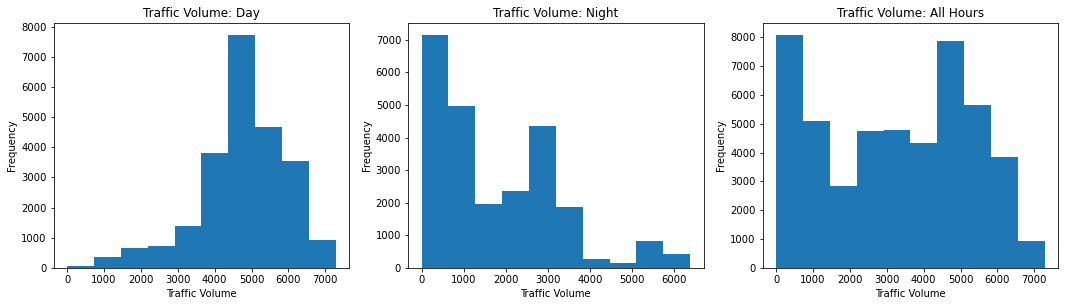

In [50]:
# Check the distribution of traffic for day and night
plt.figure(figsize=(18,4.5))

plt.subplot(1, 3, 1)
plt.hist(df_day['traffic_volume'])
plt.title('Traffic Volume: Day')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

plt.subplot(1, 3, 2)
plt.hist(df_night['traffic_volume'])
plt.title('Traffic Volume: Night')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

plt.subplot(1, 3, 3)
plt.hist(interstate['traffic_volume'])
plt.title('Traffic Volume: All Hours')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

### 1.3.1: Exploring Traffic Volume by Time of Day

Just by thinking about it, we can tell that time of day affects traffic volume because there are rush hours (usually early morning or late in the afternoon).

Day of the week may also have some impact of traffic volume. But first, let's see how time of day affects traffic on Interstate 1-94.

To better understand traffic volume changes during the day, I'll create a column which groups the daytime date into categories that represent different parts of the day, like
* Morning: between 7AM and 11AM
* Afternoon: between 11AM to 4PM
* Evening: between 4PM and 7PM, etc.

This category will help capture the effect of morning and evening rush hour on traffic volume.

In [51]:
# Create categories for time of day
#interstate['time_of_day'] = pd.Series()
interstate.loc[(interstate['date_time'].dt.hour >= 4) & (interstate['date_time'].dt.hour < 7), 'time_of_day'] = 'Early Morning' 
interstate.loc[(interstate['date_time'].dt.hour >= 7) & (interstate['date_time'].dt.hour < 10), 'time_of_day'] = 'Morning' 
interstate.loc[(interstate['date_time'].dt.hour >= 10) & (interstate['date_time'].dt.hour < 12), 'time_of_day'] = 'Noon' 
interstate.loc[(interstate['date_time'].dt.hour >= 12) & (interstate['date_time'].dt.hour < 16), 'time_of_day'] = 'Afternoon' 
interstate.loc[(interstate['date_time'].dt.hour >= 16) & (interstate['date_time'].dt.hour < 19), 'time_of_day'] = 'Evening'
interstate.loc[(interstate['date_time'].dt.hour >= 19) & (interstate['date_time'].dt.hour < 22), 'time_of_day'] = 'Late Evening'  
interstate.loc[(interstate['date_time'].dt.hour >= 22) | (interstate['date_time'].dt.hour < 4), 'time_of_day'] = 'Night' 

In [52]:
interstate['time_of_day'].value_counts(dropna=False)

Night            12164
Afternoon         7763
Early Morning     6241
Morning           6177
Late Evening      5922
Evening           5907
Noon              4030
Name: time_of_day, dtype: int64

In [53]:
traffic_by_time_of_day = interstate.groupby('time_of_day').mean()['traffic_volume'].sort_values(ascending=False)

<AxesSubplot:xlabel='traffic_volume', ylabel='time_of_day'>

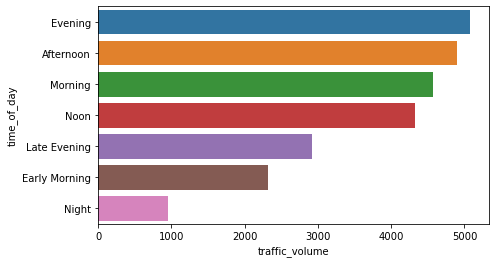

In [54]:
plt.figure(figsize=(7,4))
sns.barplot(x=traffic_by_time_of_day, y=traffic_by_time_of_day.index, orient='h')

### 1.3.2: Exploring Traffic Volume by Day of Week

Days of the week also have an impact on traffic, for instance, some days (like work days) will have higher traffic than week days and holidays. Because people have to get to work and school. So, I'll inspect the dataset to see how different days of the week affect traffic on the I-94

In [55]:
# Create a column for days of the week
interstate['day_of_week'] = interstate['date_time'].dt.day_name()

interstate.groupby('day_of_week').mean()['traffic_volume'].sort_values(ascending=True)

day_of_week
Sunday       2368.588329
Saturday     2773.638120
Monday       3309.387161
Tuesday      3488.555799
Wednesday    3583.196681
Thursday     3637.899663
Friday       3656.358836
Name: traffic_volume, dtype: float64

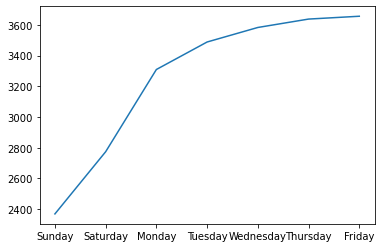

In [56]:
plt.plot(interstate.groupby('day_of_week').mean()['traffic_volume'].sort_values(ascending=True))

Looking at the chart above, we can truly see how weekdays affect traffic on the I-94. Apparently weekends (Sunday and Saturday) see the least traffic, while weekdays (Mondays to Fridays) see the most traffic.

And the traffic volume shoots up on Monday and continues to increase til Friday.

We can also see how this varies for day and night.

Text(0.5, 1.0, 'Traffic Volume: Night')

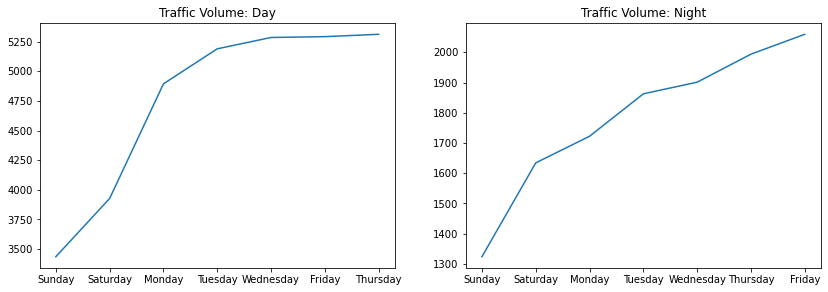

In [57]:
df_day = interstate[interstate['is_daytime'] == 'Yes']
df_night = interstate[interstate['is_daytime'] == 'No']

plt.figure(figsize=(14,4.5))

plt.subplot(1, 2, 1)
plt.plot(df_day.groupby('day_of_week').mean()['traffic_volume'].sort_values(ascending=True))
plt.title('Traffic Volume: Day')

plt.subplot(1, 2, 2)
plt.plot(df_night.groupby('day_of_week').mean()['traffic_volume'].sort_values(ascending=True))
plt.title('Traffic Volume: Night')

The pattern is not different from what we saw earlier. However, we can see that during daytime on weekdays, traffic volume reaches above 5000, which is more than double the traffic at night.

### 1.3.3: Exploring Traffic Volume by Month

Months and seasons of the year can also affect how many cars are on the road, so we will group our data by month as see how it impacts traffic volume.

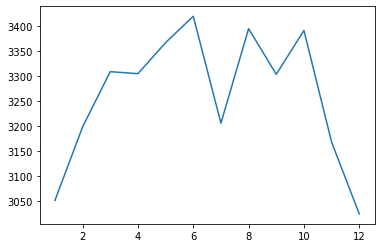

In [58]:
# Create a column for days of the week
interstate['month'] = interstate['date_time'].dt.month

plt.plot(interstate.groupby('month').mean()['traffic_volume'])

From the above plot, we can see that winter months (November, December and January) have the lowest traffic volumes, but there's a significant dip in traffic volume around July. 

This is something to investigate further. To do this, I'll plot data for the July month of every year in the dataset.

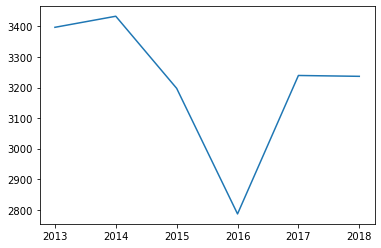

In [59]:
# Create a year column for grouping data
interstate['year'] = interstate['date_time'].dt.year

july = interstate[interstate['month']==7]

plt.plot(july.groupby('year').mean()['traffic_volume'])

So, the drop in traffic volume happened in July 2016. 

After some Google search, I discovered that I-94 was closed for several days in July 2016 for road construction and the RethinkingI-94 project. 

This explains the significant drop in traffic during this period.

Also, from the descriptive statistics of the `traffic_volume` column, we saw that the mininum value is 0, which we can see is are two occasions in July of 2016.

In [60]:
interstate[interstate['traffic_volume']==0]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,is_daytime,time_of_day,day_of_week,month,year
25186,None,296.68,0.0,0.0,40,Rain,light rain,2016-07-23 18:00:00,0,Yes,Evening,Saturday,7,2016
25191,None,295.90,0.0,0.0,90,Haze,haze,2016-07-23 23:00:00,0,No,Night,Saturday,7,2016


### 1.3.4: Exploring Traffic Volume by Hour

For this specific analysis, I'll be working with only data for daytime because this is when there is the most traffic volume, plus I also want to identify rush hour during week days.

In [61]:
# Create a column for hour
df_day['hour'] = df_day['date_time'].dt.hour

df_day['is_weekday'] = 'Yes'

df_day.loc[(df_day['day_of_week'] == 'Saturday') | (df_day['day_of_week'] == 'Sunday'), 'is_weekday'] = 'No'

df_day['is_weekday'].value_counts(dropna=False)

Yes    17085
No      6792
Name: is_weekday, dtype: int64

Text(0.5, 1.0, 'Traffic Volume by Hour on Weekends')

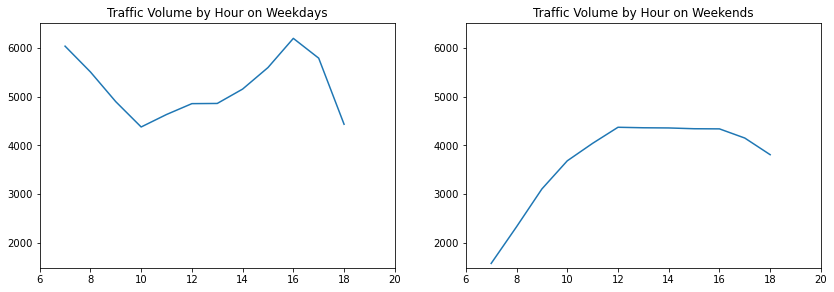

In [62]:
weekdays = df_day[df_day['is_weekday'] == 'Yes']
weekends = df_day[df_day['is_weekday'] == 'No']

plt.figure(figsize=(14,4.5))

plt.subplot(1, 2, 1)
plt.xlim(6,20)
plt.ylim(1500,6500)
plt.plot(weekdays.groupby('hour')['traffic_volume'].mean())
plt.title('Traffic Volume by Hour on Weekdays')

plt.subplot(1, 2, 2)
plt.xlim(6,20)
plt.ylim(1500,6500)
plt.plot(weekends.groupby('hour')['traffic_volume'].mean())
plt.title('Traffic Volume by Hour on Weekends')

From the above charts, I can conclusively say that traffic volume on I-94 is significantly higher on weekdays than on weekends.

And on weekdays; 
* morning rush hour is between 7AM and 8AM 
* evening rush hour is between 3PM and 5PM

To summarize what I've observed so far from time-related indicators of traffic volme on I-94:

* Traffic is usually heaviest during warm months (March–October) and lowest to cold months (November–February).
* Traffic is usually heavier on weekdays compared to weekends.
* On weekdays, the pick rush hours are around 7AM and 4PM.

### 1.4: Exploring Categorical Columns

In [63]:
interstate.select_dtypes(include='O').describe()

,holiday,weather_main,weather_description,is_daytime,time_of_day,day_of_week
count,48204,48204,48204,48204,48204,48204
unique,12,11,38,2,7,7
top,None,Clouds,sky is clear,No,Night,Monday
freq,48143,15164,11665,24327,12164,7072


In [64]:
interstate.holiday.unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [65]:
interstate.holiday.value_counts(normalize=True)*100

None                         99.873454
Labor Day                     0.014522
Thanksgiving Day              0.012447
Christmas Day                 0.012447
New Years Day                 0.012447
Martin Luther King Jr Day     0.012447
Columbus Day                  0.010373
Veterans Day                  0.010373
Washingtons Birthday          0.010373
Memorial Day                  0.010373
Independence Day              0.010373
State Fair                    0.010373
Name: holiday, dtype: float64

99% of the values in the `holiday` are None, and these are days with no holiday. There's very little variation in this column.

In [66]:
interstate.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume', 'is_daytime',
       'time_of_day', 'day_of_week', 'month', 'year'],
      dtype='object')

In [67]:
interstate.weather_main.value_counts()

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

Let's find out each weather type affects traffic volume.

<AxesSubplot:ylabel='weather_main'>

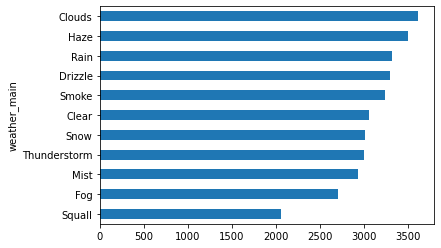

In [68]:
traffic_by_weather = interstate.groupby('weather_main').mean()

traffic_by_weather['traffic_volume'].sort_values(ascending=True).plot.barh()

There is no weather type with traffic more than 5000. Squall has the highest impact on traffic, bringing it down to less than 2500.

There's a final column which gives us more granular weather description, let's check that out.

<AxesSubplot:ylabel='weather_description'>

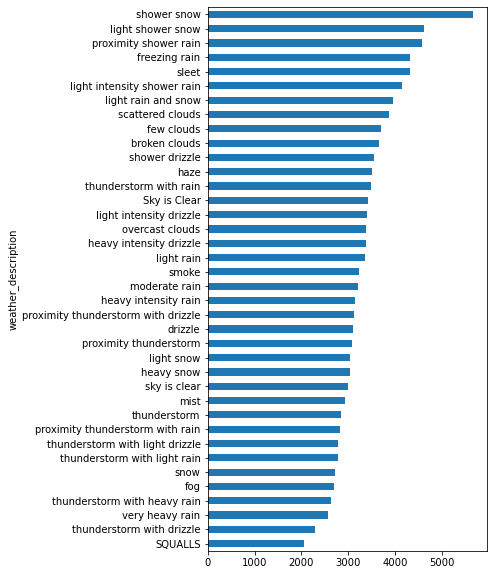

In [69]:
traffic_by_weather2 = interstate.groupby('weather_description').mean()

traffic_by_weather2['traffic_volume'].sort_values(ascending=True).plot.barh(figsize=(5,10))

By looking at the chart above, we can't really tell how bad and good weather impact traffic volume. 

In [72]:
traffic_by_weather2['traffic_volume'].sort_values(ascending=False).tail(10)

weather_description
thunderstorm                        2843.752000
proximity thunderstorm with rain    2819.269231
thunderstorm with light drizzle     2779.266667
thunderstorm with light rain        2776.833333
snow                                2712.122867
fog                                 2703.720395
thunderstorm with heavy rain        2631.142857
very heavy rain                     2568.833333
thunderstorm with drizzle           2297.000000
SQUALLS                             2061.750000
Name: traffic_volume, dtype: float64

In [ ]:
# Export new data to csv file
interstate.to_csv('new_interstate.csv')

## Conclusion

Through this analysis of the Minneapolis-St Paul, MN traffic dataset for the westbound I-94, I successfully identified noteworthy indicators of heavy traffic patterns. The analysis revealed that time is a significant traffic indicator, with clear patterns observed:

`Time of Year`: I observed that traffic tends to peak during the warmer months, spanning from March to October. Conversely, traffic volume dips during the colder months from November to February.

`Day of the Week`: This analysis revealed that weekdays consistently experience higher traffic compared to weekends. Furthermore, specific rush hours—around 7 AM and 4 PM—emerge as key times of heightened traffic.

`Weather Influence`: The impact of weather on traffic volume is undeniable. I noticed that during adverse weather conditions, traffic volume tends to decrease, indicating a connection between weather-related factors and reduced road congestion.